<a href="https://colab.research.google.com/github/Stuksus/Hackaton_SBER/blob/main/Outlieres_AngelWithKarma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Грузим данные

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter('ignore')

In [2]:
train_df = pd.read_csv('https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-train.csv', sep=';')
test_df = pd.read_csv('https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-test.csv', sep=';')
desc_df = pd.read_csv('https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-desc.csv', sep=';')

# train_df = train_df.drop(['record_id','ul_systematizing_flg'],axis = 1)
train_df["ul_staff_range"] = train_df["ul_staff_range"].replace(['[1-100]','(100-500]','> 500'],[50,300,750])

# Наши размышления

##1. Дропать пропуски нельзя. 
Мы предполагаем что в train_df пропуски являются частью *предметной области*. Компании с пропусками просто не имеют/не предоставли своих бухгалтерских отчетов.

**Детали**: пропуски в train_df составляют 46% выборки, а в test_df 59% выборки. Более того, в train_df 2% дефолтов произошло с компаниями без пропусков, а 4% дефолтов с компаниями с пропусками. Это слишком большая потеря данных

**Мы предлогаем** сделать 2 отдельные модели для данных с пропусками и без, а потом уже их в конце объеденить их в 1 submit. Попробовать обучить первую модель вообще без данных бух отчетов

Далее в коде подтверждение нашим словам

In [3]:
target = train_df['default_12m']

print(f'{(1-len(train_df.dropna()) / len(train_df))*100}% строк в train_df имеют пропуски')
print(f'{(1-len(test_df.dropna()) / len(test_df))*100}% строк в test_df имеют пропуски')
print()
print(f'{(train_df.dropna()["default_12m"].sum()/train_df["default_12m"].count())*100}% строк c пропусками из train_df объявили дефолт')

a = pd.concat([train_df, train_df.dropna()]).drop_duplicates(keep=False)['default_12m']
print(f'{(a.sum()/train_df["default_12m"].count())*100}% строк без пропусков из train_df объявили дефолт')
print(f'{(target.sum()/train_df["default_12m"].count())*100}% всего строк из train_df объявили дефолт')

46.751041827442506% строк в train_df имеют пропуски
59.00000000000001% строк в test_df имеют пропуски

2.457169316252508% строк c пропусками из train_df объявили дефолт
3.997530483099244% строк без пропусков из train_df объявили дефолт
6.454699799351752% всего строк из train_df объявили дефолт


##2. Стоит объеденить строки с идентичными столбцами бухгалтерского баланса 
Мы заметили, что существует не мало компаний прям с одинаковыми значениями в статьях баланса. Более того на частных примерах мы увидили, что компании с одинаковыми значениями в статьях баланса по остальным признакам имеют минимальные различия.

**Детали**: Компании с одинаковым бухгалтерским балансом финансово *почти* на одно и то же

**Мы предлогаем** Объеденить несколько строк с  идентичными столбцами бухгалтерского баланса  

Далее в коде подтверждение нашим словам

А также пример кода, который скидывает дубликаты (пример законментирован)

In [4]:
print(f'{train_df.duplicated().sum()/len(train_df)}% выборки train_df полные дубликаты')

a = pd.concat([train_df, train_df.dropna()]).drop_duplicates(keep=False)
print(f'{a.iloc[:,:24].duplicated().sum()/len(train_df)}% выборки train_df дубликаты по статьям расхода')
print(f'{train_df.iloc[:,24:].duplicated().sum()/len(train_df)}% выборки train_df дубликаты по НЕ статьям расхода')

# код удаляющий полные дубликаты
# train_df = train_df.drop(['record_id','ul_systematizing_flg'],axis = 1)
# train_df = train_df.drop_duplicates() 

0.0% выборки train_df полные дубликаты
0.0% выборки train_df дубликаты по статьям расхода
0.23762926377527396% выборки train_df дубликаты по НЕ статьям расхода


In [5]:
print('Вот например, 3 абсолютно одинаковые бухгалтерские статьи с минимальными отличиями в UL_,_AGE признаках')
print()
train_df.sort_values(by=['bus_age','ul_founders_cnt']).iloc[-6:-3,:]

Вот например, 3 абсолютно одинаковые бухгалтерские статьи с минимальными отличиями в UL_,_AGE признаках



,record_id,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,ar_other_profit_and_losses,ar_net_profit,ab_immobilized_assets,ab_mobile_current_assets,ab_inventory,ab_accounts_receivable,ab_other_current_assets,ab_cash_and_securities,ab_losses,ab_own_capital,ab_borrowed_capital,ab_long_term_liabilities,ab_short_term_borrowing,ab_accounts_payable,ab_other_borrowings,bus_age,ogrn_age,adr_actual_age,head_actual_age,cap_actual_age,ul_staff_range,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,ul_systematizing_flg,default_12m
12174,102598,6508000.0,7470000.0,7470000.0,0.0,0.0,-962000.0,921000.0,-41000.0,7000.0,0.0,-48000.0,0.0,5022000.0,5007000.0,15000.0,0.0,54000.0,-48000.0,4339000.0,2541000.0,0.0,340000.0,2201000.0,0.0,532,137,25,25,25,50,2003701.0,444,0,0,0,0
19056,161334,6508000.0,7470000.0,7470000.0,0.0,0.0,-962000.0,921000.0,-41000.0,7000.0,0.0,-48000.0,0.0,5022000.0,5007000.0,15000.0,0.0,54000.0,-48000.0,4339000.0,2541000.0,0.0,340000.0,2201000.0,0.0,532,138,25,25,25,50,2003701.0,444,0,0,0,0
21846,185243,6508000.0,7470000.0,7470000.0,0.0,0.0,-962000.0,921000.0,-41000.0,7000.0,0.0,-48000.0,0.0,5022000.0,5007000.0,15000.0,0.0,54000.0,-48000.0,4339000.0,2541000.0,0.0,340000.0,2201000.0,0.0,534,140,28,28,28,50,2003701.0,444,0,0,0,0


##3. Надо выбросить компании с отрицательными значениями статей баланса
Мы заметили, что в некторых статьях есть отрицательные значения. По МСФО таких статей не должно существовать. Более того, таких компаний не много и они не объявляли дефолт. Однако если выбросить все отрицательные наблюдения, то мы теряем 40% выборки, так как столбцы с profit могут быть отрицательными. Поэтому тут функция по дефолту скидывает отрицательные значения в НЕ profit столбцах. 


Далее в коде подтверждение нашим словам

А также функция, которая скидывает компании с отрицательными занчениями 

### 3.a Тута технический код на него не надо смотреть (надо запустить и скрыть)

In [53]:
# Тута технический код на него не надо смотреть
class Grapher:
    def __init__(self, 
                 train, test=[], target_col = 'default_12m',
                 figsize = (10,5), target_colors = {0:'gray',1:'red'}
                 ):         

        self.df_original = (train,test)
        self.target = train[target_col]
        self.df = train.drop(columns=[target_col])
        self.dfs_by_target = [train[train[target_col]==target_value] for target_value in train[target_col].unique()]

        self.test = test

        self.plt_figsize = figsize
        self.plt_colored_target = self.target.map(target_colors)
        self.fplt_dims = {self.scatter:2,
                          self.scatter3d:3,
                          self.hist:1}

    def show_cyclic(self,fplt):
        '''
        shows #[n-constant] fplt plots of df with cyclic change in the dimensions
        Example:
            g = Grapher( pd.DataFrame({a:[],b:[],c:[]}) )
            g.show_cyclic(g.scatter) 
            -> 
            prints scatter plots with cyclic change in the dimensions:
            g.scatter(a,b);g.scatter(b,c);g.scatter(c,a)
        !: 
            it will show #[n-constant] graphics (it is almost always less than #qty of df columns)
        '''

        n=self.fplt_dims[fplt]
        index_start = 0
        for i in range(len(self.df.columns)-n):
            fplt(*(self.df.columns[0+i:n+i]))

    
    def show_all(self,fplt):
        '''
        shows all possible fplt plots of df
        Example:
            g = Grapher( pd.DataFrame({a:[],b:[],c:[]}) )
            g.show_all(g.scatter) 
            -> 
            prints all possible scatter plots:
            g.scatter(a,b);g.scatter(a,c);g.scatter(b,c)
        !: 
            if many df columns then there are too many graphs to show
        '''

        from itertools import combinations as combi
        n=self.fplt_dims[fplt]

        for dims in combi(self.df.columns,n):
            fplt(*dims)

    def show_separate(self, fplt):
        '''
        should show 3 fplt plots side by side: 
        {{default+alive,default,alive}}
        In general should show n+1 fplt plots side by side:
        {{everething, target_group_1, target_group_2, ... , target_group_n}}
        '''
        # all = self.df
        # dead = all[self.target == 1]
        # alive = all[all[self.target != 1]

        # all = Grapher(train=all)
        # dead = Grapher(train=dead)
        # alive = Grapher(train=alive)

        # all.scatter3d()
        # dead.scatter3d()
        # alive.scatter3d()
        pass
    
    def scatter(self,
                x_name = 'bus_age', y_name = 'ul_capital_sum',
                alpha = 0.3,
                xscale = 'linear',
                yscale = 'linear'
                ):
        
        fig, ax = plt.subplots(figsize=self.plt_figsize)

        ax.scatter(
                x = self.df[x_name], 
                y = self.df[y_name], 
                c = self.plt_colored_target,
                alpha = alpha
                )
        ax.set_xscale(xscale)
        ax.set_yscale(yscale)
        plt.xlabel(x_name)
        plt.ylabel(y_name)

        plt.show()

    def scatter3d(self,
                  x_name='ul_capital_sum',
                  y_name='ul_founders_cnt',
                  z_name='bus_age',
                  alpha = 0.3,
                  xscale = 'linear',
                  yscale = 'linear',
                  zscale = 'linear'):
        
        fig = plt.figure(figsize=self.plt_figsize)
        ax = fig.add_subplot(projection='3d')

        ax.scatter(self.df[x_name], 
                   self.df[y_name], 
                   self.df[z_name], 
                   c = self.plt_colored_target,
                   alpha = alpha)
        
        ax.set_xscale(xscale)
        ax.set_yscale(yscale)
        ax.set_zscale(zscale)
        ax.set_xlabel(x_name)
        ax.set_ylabel(y_name)
        ax.set_zlabel(z_name)

        plt.show()

    def hist(self,
             x_name='ar_revenue',
             n_bins = 30,
             alpha = 0.3,
             xscale = 'linear',):
        
        fig, ax =  plt.subplots(figsize=self.plt_figsize)

        
        # for i,color in self.plt_colored_target.items():
        dim_0 = self.df[self.target == 0][x_name]
        dim_1 = self.df[self.target != 0][x_name]
        ax.hist(dim_0, n_bins, stacked=True, density=False,color='Gray')
        ax.hist(dim_1, n_bins, stacked=True, density=False,color='Red')


        ax.set_xlabel(x_name)
        # ax.set_title('Scores by group and gender')
        # ax.legend()

        plt.show()

    def hist3d(self, n_bins = 10):
        pass

df_ab = train_df.iloc[:,:24]
df_ab['default_12m'] = train_df['default_12m'] 

size = (6,3)
g = Grapher(train = df_ab, figsize=size)
gt = Grapher(train = df_ab[df_ab.default_12m == 0], figsize=size)
gm = Grapher(train = df_ab[df_ab.default_12m != 0], figsize=size)

### 3.b На графиках можно видеть что отрицательных данные есть и их вроде не много

Каждая точка это одна компания. Серая точка НЕ объявила дефолт, крансная объявила дефолт.

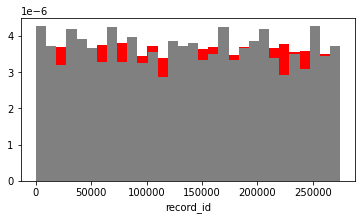

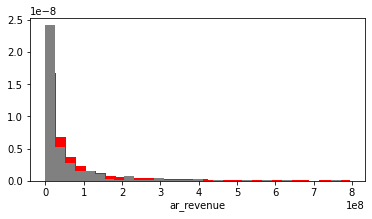

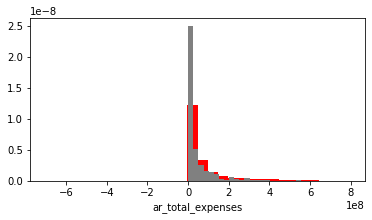

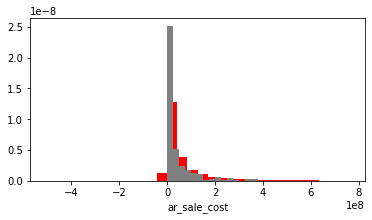

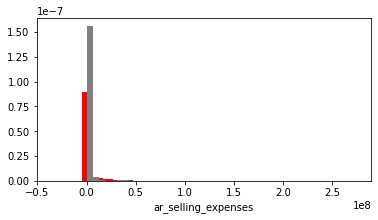

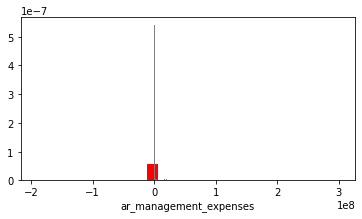

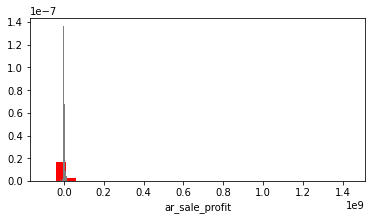

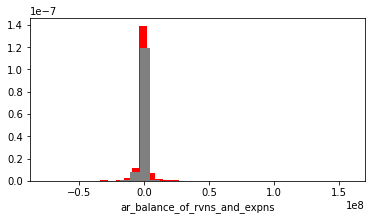

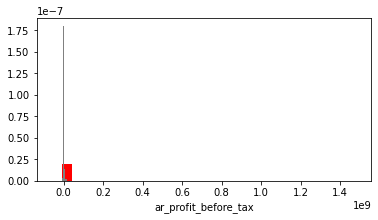

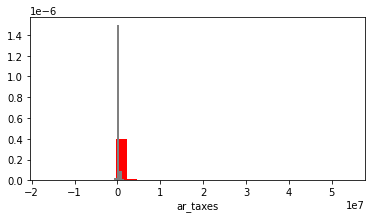

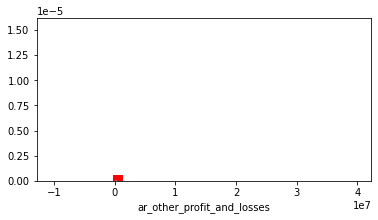

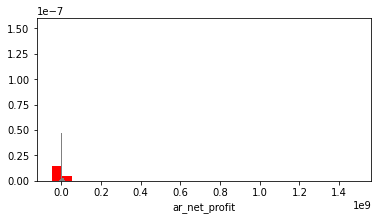

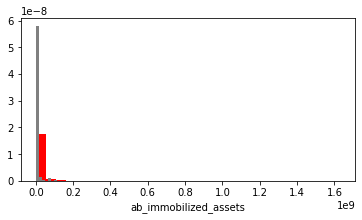

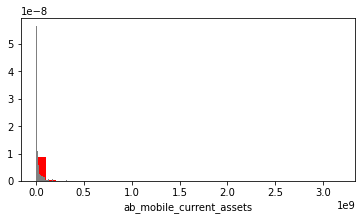

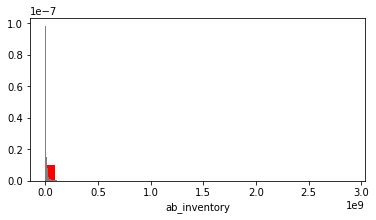

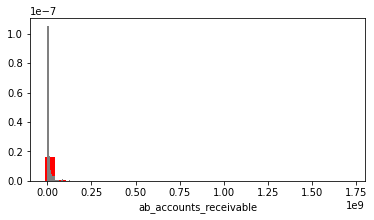

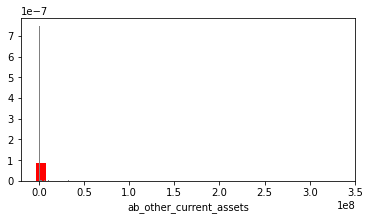

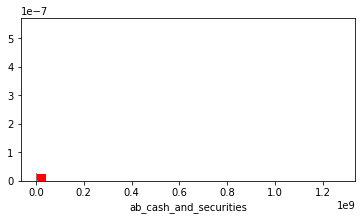

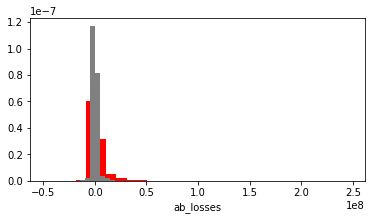

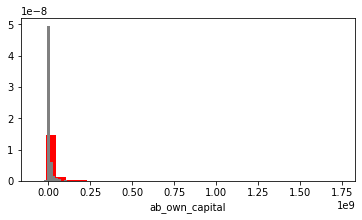

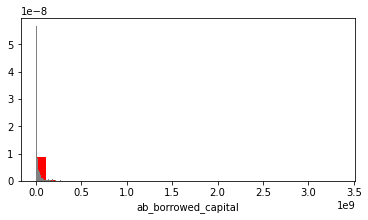

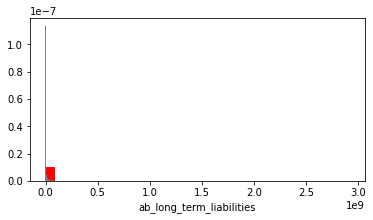

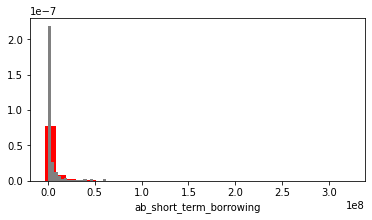

In [54]:
g.show_cyclic(g.hist)

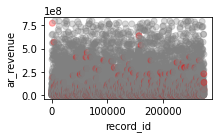

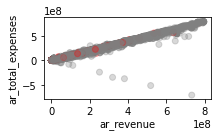

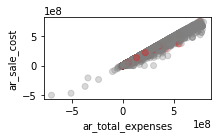

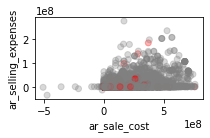

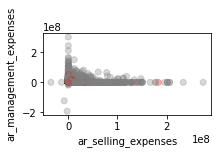

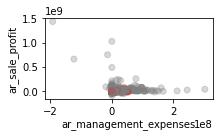

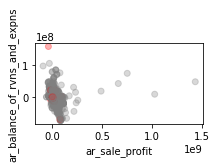

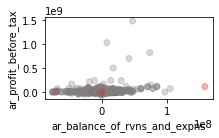

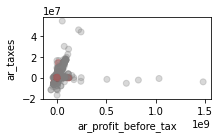

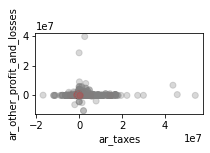

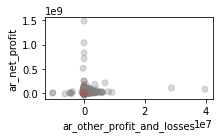

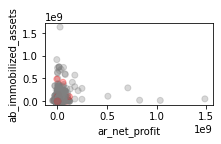

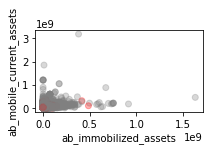

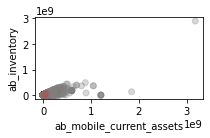

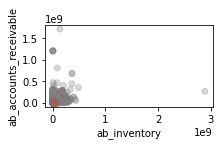

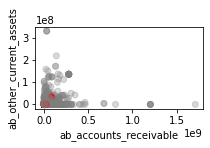

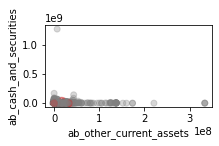

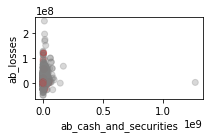

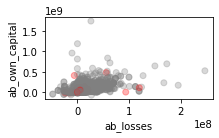

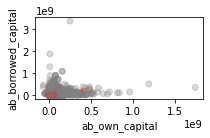

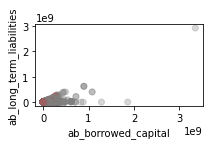

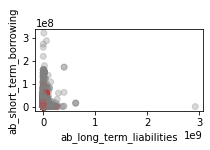

In [7]:
g.show_cyclic(g.scatter)

### 3.с Тута функция которая возвращает df с положительными

In [131]:
def remove_all_negs(df = train_df):
    k = df.min()
    return remove_cols_negs(df = train_df, cols=k[k<0].keys())

def remove_cols_negs(df = train_df, cols=[1*'ar_total_expenses',
                                              1*'ar_sale_cost',
                                              1*'ar_selling_expenses',
                                              1*'ar_management_expenses',
                                              0*'ar_sale_profit',
                                              0*'ar_balance_of_rvns_and_expns',
                                              0*'ar_profit_before_tax',
                                              1*'ar_taxes',
                                              0*'ar_other_profit_and_losses',
                                              0*'ar_net_profit',
                                              1*'ab_accounts_receivable',
                                              1*'ab_other_current_assets',
                                              1*'ab_losses',
                                              1*'ab_own_capital',
                                              1*'ab_long_term_liabilities',
                                              1*'ab_short_term_borrowing',
                                              1*'ab_other_borrowings']):
    for column_with_negs in cols:
        if column_with_negs == '':
            continue
        df = df[(train_df[column_with_negs]>=0) | (train_df[column_with_negs].isna())]
    return df


Если убрать ar_total_expenses, теряется 6.621392190152804% выборки
Если убрать все отрицательные значения, теряется 40.79950609661985% выборки


In [132]:
print(f'Если убрать все кроме столбцов с profit, теряется {100-len(remove_cols_negs())/len(train_df)*100}% выборки')
print(f'Если убрать все отрицательные значения, теряется {100-len(remove_all_negs())/len(train_df)*100}% выборки')

Если убрать все кроме столбцов с profit, теряется 6.621392190152804% выборки
Если убрать все отрицательные значения, теряется 40.79950609661985% выборки


## 4. Функции, которые разбивают на 2 выборки (с и без фин отчетности)

In [94]:
def sep_df_byfin(df = train_df):
    df_nofin = get_df_nofin(df = train_df)
    df_fin   = get_df_fin(df = train_df)
    return df_fin, df_nofin
    
def get_df_nofin(df = train_df):
    return train_df.dropna()

def get_df_fin(df = train_df):
    return pd.concat([train_df, train_df.dropna()]).drop_duplicates(keep=False)['default_12m']

print(f'{100*len(get_df_fin(df = train_df))/len(train_df)}% компаний имеют фин отчетность')
print(f'{100*len(get_df_nofin(df = train_df))/len(train_df)}% компаний НЕ имеют фин отчетность')

46.751041827442506% компаний имеют фин отчетность
53.248958172557494% компаний НЕ имеют фин отчетность


## 5. И да, тут очень странный чувак

In [ ]:
# train_df[train_df['record_id'] != 196113] #этот чувак очень странный